In [4]:
#Loading the data :
from google.colab import files
uploaded = files.upload()

Saving train2024.csv to train2024.csv


In [5]:
#Loading the data :
from google.colab import files
uploaded = files.upload()

Saving test2024.csv to test2024.csv


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from keras.models import Sequential

from keras.preprocessing.sequence import pad_sequences


from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model



In [6]:
train_data = pd.read_csv('train2024.csv')
test_data =  pd.read_csv('test2024.csv')

In [16]:

print("Training Data Preview:")
print(train_data.head())


print("\n" + "-"*50 + "\n")

print("Test Data Preview:")
print(test_data.head())


Training Data Preview:
             id  clothing_id  age                    title  \
0  riGPBydm2l8e          767   33                      NaN   
1  CTVvQyR3luQK         1077   60  Some major design flaws   
2  lIod6hI0Wxvn          847   47         Flattering shirt   
3  meKOrcX2BXUk         1080   49  Not for the very petite   
4  HKVXQ5htsPmJ         1077   24               Flattering   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            review_text  \
0                                                                                                

In [7]:
print("Training Data info:")
print(train_data.info())
print(train_data.isnull().sum())


print("\n" + "-"*50 + "\n")

print("Testing Data info:")
print(test_data.info())
print(test_data.isnull().sum())


Training Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16441 entries, 0 to 16440
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       16441 non-null  object
 1   clothing_id              16441 non-null  int64 
 2   age                      16441 non-null  int64 
 3   title                    13801 non-null  object
 4   review_text              15849 non-null  object
 5   rating                   16441 non-null  int64 
 6   recommended_ind          16441 non-null  int64 
 7   positive_feedback_count  16441 non-null  int64 
 8   division_name            16430 non-null  object
 9   department_name          16430 non-null  object
 10  class_name               16430 non-null  object
dtypes: int64(5), object(6)
memory usage: 1.4+ MB
None
id                            0
clothing_id                   0
age                           0
title                      2640

I will make a full report for my univariate analysis for the train data to see the variables distributions and  check for class imbalance

In [8]:
!pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 41.5 MB/s eta 0:00:00


In [9]:
import sweetviz as sv


#
report = sv.analyze(train_data)

report.show_html('Sweetviz_Report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Sweetviz_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
from google.colab import files
files.download('Sweetviz_Report.html')


Some EDA

In [10]:
# i will Check the ratings classes distributions :
class_distribution = train_data['rating'].value_counts()
print(f"class distribution:\n{class_distribution}")

## We notice a huge imbalance as 56% ( from the report ) of classes are rating 5 which can cause overfitting

class distribution:
rating
5    9192
4    3555
3    2022
2    1100
1     572
Name: count, dtype: int64


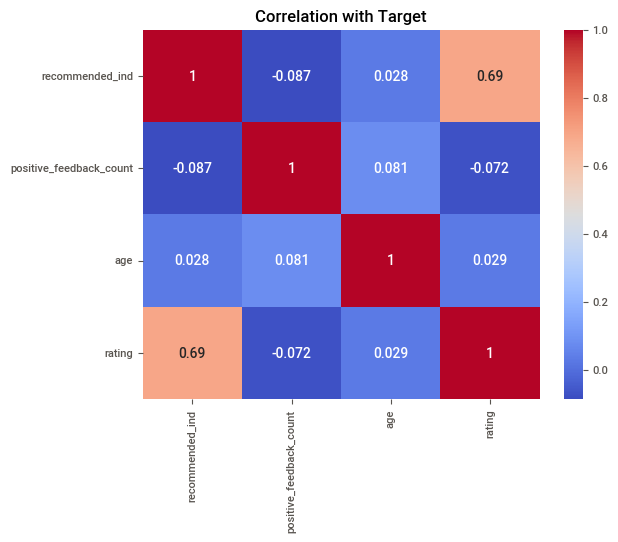

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = train_data[['recommended_ind', 'positive_feedback_count', 'age', 'rating']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation with Target")
plt.show()

 ## The only variable that is correlated with our target variable is recommended_ind

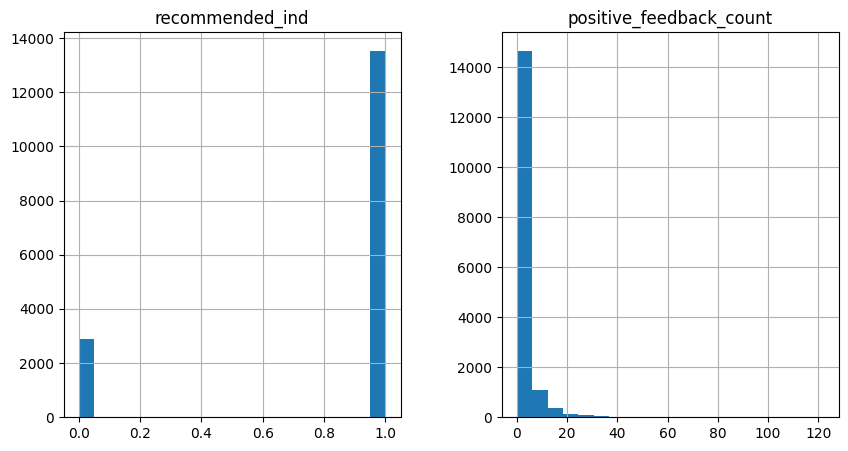

In [ ]:
train_data[['recommended_ind', 'positive_feedback_count']].hist(bins=20, figsize=(10, 5))
plt.show()


In [ ]:
for feature in ['division_name', 'department_name', 'class_name']:
    print(f"Feature: {feature}")
    print(train_data[feature].value_counts(), "\n")


Feature: division_name
division_name
General           9623
General Petite    5740
Initmates         1067
Name: count, dtype: int64 

Feature: department_name
department_name
Tops        7265
Dresses     4421
Bottoms     2702
Intimate    1234
Jackets      715
Trend         93
Name: count, dtype: int64 

Feature: class_name
class_name
Dresses           4421
Knits             3388
Blouses           2123
Sweaters          1010
Pants              981
Jeans              800
Fine gauge         744
Skirts             681
Lounge             494
Jackets            485
Swim               252
Shorts             238
Outerwear          230
Sleep              153
Legwear            125
Layering           106
Intimates          103
Trend               93
Casual bottoms       2
Chemises             1
Name: count, dtype: int64 



In [ ]:
for feature in ['division_name', 'department_name', 'class_name']:
    pivot = train_data.groupby(feature)['rating'].mean()
    print(f"Mean Target Values for {feature}:\n", pivot, "\n")


Mean Target Values for division_name:
 division_name
General           4.178427
General Petite    4.207143
Initmates         4.315839
Name: rating, dtype: float64 

Mean Target Values for department_name:
 department_name
Bottoms     4.278682
Dresses     4.147252
Intimate    4.316045
Jackets     4.293706
Tops        4.172058
Trend       3.881720
Name: rating, dtype: float64 

Mean Target Values for class_name:
 class_name
Blouses           4.171455
Casual bottoms    4.500000
Chemises          4.000000
Dresses           4.147252
Fine gauge        4.250000
Intimates         4.291262
Jackets           4.329897
Jeans             4.397500
Knits             4.146694
Layering          4.377358
Legwear           4.416000
Lounge            4.352227
Outerwear         4.217391
Pants             4.229358
Shorts            4.235294
Skirts            4.224670
Sleep             4.320261
Sweaters          4.200990
Swim              4.178571
Trend             3.881720
Name: rating, dtype: float64 



In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculate VIF
X = train_data[['recommended_ind', 'positive_feedback_count']]
X = add_constant(X)

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


                   Feature       VIF
0                    const  6.012975
1          recommended_ind  1.005064
2  positive_feedback_count  1.005064


Here i defined my stopwords . i eliminated them in many approaches before but for my highest public score i didn't . The same for lemmatizing , i didn't do for this appraoch

In [38]:
!pip install nltk


In [41]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# Loading English stopwords
stop_words = set(stopwords.words('english'))


# here i defined some of the negations and sentiment modifiers that i thought it will be better to retain them :
important_words = {'not', 'no', 'never', 'very', 'quite', 'almost', 'too', 'just', 'only', 'really', 'somewhat', 'rather', 'extremely', 'most','but','however'}


stopwordss = stop_words - important_words
print(stopwordss)


{'themselves', 'during', 'why', 'ain', 'as', "shan't", 'd', 'ours', 'our', 'wouldn', 'shan', "couldn't", 'itself', "haven't", 'yourselves', 'nor', 'my', 'were', "shouldn't", 'you', 'its', 'they', 'herself', 'between', 'had', "mustn't", 'and', "you've", "doesn't", 'above', 'o', 'then', "you're", 'these', 'is', 'at', 'who', 'now', 'if', 'down', 'it', 'this', 'didn', 'up', 'she', 'what', 'shouldn', 'haven', 'being', 'because', 'through', 'isn', 'am', "won't", 'her', "you'll", 'wasn', 'again', 'that', 'so', 'doesn', 'mightn', 'm', 'himself', 'with', 'them', 'hasn', "you'd", "wasn't", 'myself', 'same', "aren't", 'aren', 'other', 've', 'those', 'should', 'here', 'yourself', 'has', "didn't", 'about', 'whom', 'mustn', 'both', 'there', 'yours', "she's", 't', 'such', 'all', 'couldn', 'few', 'below', 'will', 'weren', 'in', "that'll", 'y', "weren't", "should've", 'are', 'won', 'into', 'his', 'more', 's', 'before', 'by', 'of', 'than', 'does', 'any', "don't", 'where', 'can', 'don', 'until', 're', 't

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')  # Tokenizer
nltk.download('wordnet')
nltk.download('punkt_tab')
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Tokenizing the text
    words = word_tokenize(text)
    # Lemmatizing each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(lemmatized_words)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

text(the titles and reviews ) cleaning i did for this approach :

In [8]:

train_data['title'] = train_data['title'].fillna('No title provided')
train_data['review_text'] = train_data['review_text'].fillna('No review provided')

test_data['title'] = test_data['title'].fillna('No title provided')
test_data['review_text'] = test_data['review_text'].fillna('No review provided')


train_data['title'] = train_data['title'].astype(str)
train_data['review_text'] = train_data['review_text'].astype(str)
test_data['title'] = test_data['title'].astype(str)
test_data['review_text'] = test_data['review_text'].astype(str)


train_data['full_text'] = train_data['title'] + " " + train_data['review_text']
test_data['full_text'] = test_data['title'] + " " + test_data['review_text']


pd.set_option('display.max_colwidth', None)
print(train_data['full_text'].head())
print(test_data['full_text'].head())



0                                                                                                                                                                                                                                                                                                                                                                                                                                                                         No title provided Absolutely wonderful - silky and sexy and comfortable
1    Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw 

In [9]:
import re

def text_cleaning(text):
    text = text.lower()  # convert text to lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)  # remove repeated words
    text = re.sub(r'([a-z])\1{2,}', r'\1', text)  # reduce elongated words to two letters
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\r\n|\r|\n', ' ', text)  # remove new lines and carriage returns
    text = re.sub(r'\s{2,}', ' ', text)  # replace multiple spaces with a single space

    return text

# Function to replace specific punctuation with tokens
def punctuation(text):
    text = text.replace('!', ' EXCLAMATION ')
    text = text.replace('?', ' QUESTION ')
    return re.sub(r'[^\w\s]', '', text)



train_data['full_text'] = train_data['full_text'].apply(punctuation).apply(text_cleaning)
test_data['full_text'] = test_data['full_text'].apply(punctuation).apply(text_cleaning)


print(train_data['full_text'])
print(test_data['full_text'])


0                                                                                                                                                                                                                                                                                                                                                                                                                                                                            no title provided absolutely wonderful silky and sexy and comfortable
1        some major design flaws i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up exclamation i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design f

Feature engineering for this approach :  

In [10]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


## Handling missing values and combine sparse categories
def numerical_features(data):

    data['class_name'].fillna('Missing', inplace=True)
    data['division_name'].fillna('Missing', inplace=True)
    data['department_name'].fillna('Missing', inplace=True)

    #@# Combine sparse categories
    threshold = 100
    value_counts = data['class_name'].value_counts()
    to_combine = value_counts[value_counts <= threshold].index
    data['class_name'] = data['class_name'].apply(lambda x: 'Other' if x in to_combine else x)

    return data

train_data = numerical_features(train_data)
test_data = numerical_features(test_data)

### One hot encoding :
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(train_data[['division_name', 'department_name', 'class_name']])
encoded_test_features = encoder.transform(test_data[['division_name', 'department_name', 'class_name']])

# i will Normalize only age since recommended_ind is binary :
scaler = MinMaxScaler()
train_data['age'] = scaler.fit_transform(train_data[['age']])
test_data['age'] = scaler.transform(test_data[['age']])

non_text_features = np.hstack((encoded_features, train_data[['age', 'recommended_ind']].values))
non_text_test_features = np.hstack((encoded_test_features, test_data[['age', 'recommended_ind']].values))

print(non_text_features[:5])
print(non_text_test_features[:5])


[[0.         0.         1.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.18518519
  1.        ]
 [1.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.51851852
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.35802469
  1.        ]
 [1.         0.         0.        

<ipython-input-10-908a54db5199>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['class_name'].fillna('Missing', inplace=True)
<ipython-input-10-908a54db5199>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [11]:
print(non_text_features.shape)
print(non_text_test_features.shape)


(16441, 31)
(7045, 31)


In [ ]:
## Adjusting the labels to go with what keras expects :
y_train = train_data['rating'].values - 1

To solve the class imbalance , i tried previously to oversample the minority classes but i didn't get good results so for this approach i decided to use class weights instead

In [ ]:
from sklearn.utils.class_weight import compute_class_weight



class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)


The custom trained Word2Vec embeddings : ( i found an article where they tried many models with different embeddings and most of the times when they used Word2Vec the model performed better so this is form where i got the idea to try it . This is not pretrained but trained on my data )


In [14]:
from gensim.models import Word2Vec
# Tokenize text data
train_tokens = [text.split() for text in train_data['full_text']]
test_tokens = [text.split() for text in test_data['full_text']]

# Train custom Word2Vec model
word2vec_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Step 2: Create the embedding matrix
vocab_size = len(word2vec_model.wv.index_to_key)  # Number of unique words in the Word2Vec model
embedding_dim = word2vec_model.vector_size         # Embedding dimension
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}

for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

print("Embedding matrix shape:", embedding_matrix.shape)

# Step 3: Convert tokenized sequences to word indices
train_sequences = [[word_index[word] for word in tokens if word in word_index] for tokens in train_tokens]
test_sequences = [[word_index[word] for word in tokens if word in word_index] for tokens in test_tokens]

# Step 4: Determine max_seq_length and pad sequences
review_lengths = [len(seq) for seq in train_sequences]
max_seq_length = int(np.percentile(review_lengths, 95))  # 95th percentile of review lengths
print("Max sequence length:", max_seq_length)

train_sequences_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post', truncating='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post', truncating='post')

print("Padded train shape:", train_sequences_padded.shape)
print("Padded test shape:", test_sequences_padded.shape)




Embedding matrix shape: (15733, 100)
Max sequence length: 104
Padded train shape: (16441, 104)
Padded test shape: (7045, 104)


CNN-BILSTM MODEL (THE BEST ONE )

In [23]:
class_weights2 = {
    4: 0.35772410791993037,
    3: 0.9249507735583685,
    2: 1.626211671612265,
    1: 2.989272727272727,
    0: 5.748601398601399
    }
print(class_weights2)

{4: 0.35772410791993037, 3: 0.9249507735583685, 2: 1.626211671612265, 1: 2.989272727272727, 0: 5.748601398601399}


In [29]:
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, concatenate

# Input layers
input_text = Input(shape=(max_seq_length,))
input_non_text = Input(shape=(non_text_features.shape[1],))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_seq_length,
                            trainable=True)(input_text)

# CNN branch
cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)

# BiLSTM branch
bilstm_layer = Bidirectional(LSTM(64))(cnn_layer)
bilstm_layer = Dropout(0.3)(bilstm_layer)

# Non-text branch
non_text_layer = Dense(64, activation='relu')(input_non_text)
non_text_layer = Dropout(0.3)(non_text_layer)

# Concatenate branches
concatenated = concatenate([bilstm_layer, non_text_layer])
output = Dense(5, activation='softmax')(concatenated)

# Compile the model
modelr = Model(inputs=[input_text, input_non_text], outputs=output)
modelr.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

modelr.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 104)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 104, 100)       │      1,573,300 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 102, 128)       │         38,528 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 51, 128)        │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 128)            │         98,816 │ max_pooling1d_3[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          2,048 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 192)            │              0 │ dropout_6[0][0],       │
│ (Concatenate)             │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │            965 │ concatenate_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,713,657 (6.54 MB)

 Trainable params: 1,713,657 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
## To go with our loss function :
y_train = to_categorical(y_train)
print(y_train.shape)


(16441, 5)


In [55]:
print(train_sequences_padded.shape)
print(non_text_features.shape)


(16441, 104)
(16441, 31)


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='cnn_bilstm_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)




In [57]:
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [31]:
# Training the model
history = modelr.fit([train_sequences_padded, non_text_features], y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=32,
                    class_weight=class_weights2,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/20
408/411 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4135 - loss: 1.4880
Epoch 1: val_loss improved from inf to 1.10281, saving model to cnn_bilstm_best_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4144 - loss: 1.4864 - val_accuracy: 0.5202 - val_loss: 1.1028
Epoch 2/20
406/411 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6062 - loss: 1.0893
Epoch 2: val_loss improved from 1.10281 to 0.87935, saving model to cnn_bilstm_best_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6063 - loss: 1.0889 - val_accuracy: 0.6245 - val_loss: 0.8794
Epoch 3/20
408/411 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6373 - loss: 0.9762
Epoch 3: val_loss did not improve from 0.87935
411/411 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6373 - loss: 0.9763 - val_accuracy: 0.6002 - val_loss: 0.9111
Epoch 4/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6632 - loss: 0.9164
Epoch 4: val_loss improved from 0.87935 to 0.82270, saving model 

In [34]:
from keras.models import load_model
# Loading the best saved model
best_modell1 = load_model('cnn_bilstm_best_model.keras')


In [36]:
test_predictions = modelr.predict([test_sequences_padded, non_text_test_features])
predicted_ratings = test_predictions.argmax(axis=1) + 1  # Converting the probabilities back to ratings

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [143]:
import pandas as pd

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'rating': predicted_ratings
})


submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")


Submission file created: submission.csv


In [ ]:
from google.colab import files
files.download('submission.csv')

i tried many methods and models before and after my best model , these are some of them :

I tried to manually adjust the weights to maybe balance the training better , it gave good results with a CNN-RNN model i previously tried but not my best model CNN-BILSTM

In [15]:
class_weight3 = {
    0: 6.5,
    1: 5.5,
    2: 5.5,
    3: 2.0,
    4: 0.9
}
print(class_weight3)

{0: 6.5, 1: 5.5, 2: 5.5, 3: 2.0, 4: 0.9}


After the good results of the CNN-BILSTM , i tried a CNN-BIGRU but it gave me less results than the previous one ( 0.499)

In [127]:

from keras.layers import  GRU


# Input layers
input_text = Input(shape=(max_seq_length,))
input_non_text = Input(shape=(non_text_features.shape[1],))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_seq_length,
                            trainable=True)(input_text)

# CNN branch
cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)

# BiGRU branch
bigru_layer = Bidirectional(GRU(64, return_sequences=False))(cnn_layer)


# Non-text branch
non_text_layer = Dense(64, activation='relu')(input_non_text)
non_text_layer = Dropout(0.3)(non_text_layer)

# Concatenate branches
concatenated = concatenate([bigru_layer, non_text_layer])
output = Dense(5, activation='softmax')(concatenated)

# Compile
model_gru = Model(inputs=[input_text, input_non_text], outputs=output)
model_gru.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


model_gru.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 104)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_18 (Embedding)  │ (None, 104, 100)       │      1,575,500 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 102, 128)       │         38,528 │ embedding_18[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_37            │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_19          │ (None, 51, 128)        │              0 │ conv1d_21[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 64)             │          2,048 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_16          │ (None, 128)            │         74,496 │ max_pooling1d_19[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 64)             │              0 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 192)            │              0 │ bidirectional_16[0][0… │
│ (Concatenate)             │                        │                │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 5)              │            965 │ concatenate_15[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,691,537 (6.45 MB)

 Trainable params: 1,691,537 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:

history = model_gru.fit(
    [train_sequences_padded, non_text_features],
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    class_weight=class_weights2,
    callbacks=[early_stopping,checkpoint],
    verbose=1
)


Epoch 1/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3960 - loss: 1.4753
Epoch 1: val_loss improved from inf to 0.99046, saving model to best_cnn_gru_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.3962 - loss: 1.4750 - val_accuracy: 0.5844 - val_loss: 0.9905 - learning_rate: 5.0000e-04
Epoch 2/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5944 - loss: 1.1102
Epoch 2: val_loss improved from 0.99046 to 0.90177, saving model to best_cnn_gru_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.5945 - loss: 1.1101 - val_accuracy: 0.5923 - val_loss: 0.9018 - learning_rate: 5.0000e-04
Epoch 3/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6437 - loss: 0.9573
Epoch 3: val_loss improved from 0.90177 to 0.81957, saving model to best_cnn_gru_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.6437 - loss: 0.9573 - val_accuracy: 0.6339 - val_loss: 0.8196 - learning_rate: 5.0000e-04
Epoch 4/20
411/41

I tried enhancing the CNN-BILSTM model but it didn't give better results

In [56]:

from keras.layers import  BatchNormalization


# Input layers
input_text = Input(shape=(max_seq_length,))
input_non_text = Input(shape=(non_text_features.shape[1],))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_seq_length,
                            trainable=True)(input_text)

# CNN branch with two Conv1D layers
cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)

cnn_layer = Conv1D(filters=64, kernel_size=2, activation='relu')(cnn_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)

# BiLSTM branch
bilstm_layer = Bidirectional(LSTM(128))(cnn_layer)
bilstm_layer = Dropout(0.3)(bilstm_layer)

# Non-text branch
non_text_layer = Dense(64, activation='relu')(input_non_text)
non_text_layer = BatchNormalization()(non_text_layer)
non_text_layer = Dropout(0.3)(non_text_layer)
concatenated = concatenate([bilstm_layer, non_text_layer])
output = Dense(5, activation='softmax')(concatenated)


modelr = Model(inputs=[input_text, input_non_text], outputs=output)
modelr.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])

modelr.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 104)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 104, 100)       │      1,575,500 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 102, 128)       │         38,528 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_9           │ (None, 51, 128)        │              0 │ conv1d_11[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 51, 128)        │            512 │ max_pooling1d_9[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 50, 64)         │         16,448 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_19            │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_10          │ (None, 25, 64)         │              0 │ conv1d_12[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │          2,048 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 256)            │        197,632 │ max_pooling1d_10[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64)             │            256 │ dense_12[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 256)            │              0 │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 320)            │              0 │ dropout_10[0][0],      │
│ (Concatenate)             │                        │                │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 5)              │          1,605 │ concatenate_6[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,832,529 (6.99 MB)

 Trainable params: 1,832,145 (6.99 MB)

 Non-trainable params: 384 (1.50 KB)

TRAINING THE  ENHANCED MODEL

In [49]:



history = modelr.fit([train_sequences_padded, non_text_features], y_train,
                     validation_split=0.2,
                     epochs=40,
                     batch_size=32,
                     class_weight=class_weights2,
                     callbacks=[checkpoint, early_stopping])

Epoch 1/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4049 - loss: 1.4670
Epoch 1: val_loss improved from inf to 0.88427, saving model to best_cnn_enhanced_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.4051 - loss: 1.4666 - val_accuracy: 0.6345 - val_loss: 0.8843 - learning_rate: 5.0000e-04
Epoch 2/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5979 - loss: 1.0702
Epoch 2: val_loss did not improve from 0.88427
411/411 ━━━━━━━━━━━━━━━━━━━━ 50s 122ms/step - accuracy: 0.5979 - loss: 1.0702 - val_accuracy: 0.5421 - val_loss: 0.9865 - learning_rate: 5.0000e-04
Epoch 3/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6355 - loss: 0.9398
Epoch 3: val_loss improved from 0.88427 to 0.86390, saving model to best_cnn_enhanced_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.6355 - loss: 0.9398 - val_accuracy: 0.6126 - val_loss: 0.8639 - learning_rate: 5.0000e-04
Epoch 4/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

This is one is the first Bilstm model i tried with this preprocessing

In [63]:
from keras.models import Model
from keras.layers import Input, Dense, concatenate, Bidirectional, LSTM
from keras.layers import Reshape

# Input layers
input_text = Input(shape=(100,))
input_non_text = Input(shape=(non_text_features.shape[1],))

# Text branch
text_layer = Dense(128, activation='relu')(input_text)
text_layer = Reshape((1, 128))(text_layer)
text_bi_lstm = Bidirectional(LSTM(64))(text_layer)



# Non-text branch
non_text_layer = Dense(64, activation='relu')(input_non_text)
non_text_layer = Dropout(0.3)(non_text_layer)
# Concatenate branches
concatenated = concatenate([text_bi_lstm, non_text_layer])
output = Dense(5, activation='softmax')(concatenated)

# Compile
model = Model(inputs=[input_text, input_non_text], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │         12,928 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 33)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 128)         │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │          4,352 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 128)            │         98,816 │ reshape_4[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 256)            │              0 │ bidirectional_4[0][0], │
│ (Concatenate)             │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 5)              │          1,285 │ concatenate_4[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 117,381 (458.52 KB)

 Trainable params: 117,381 (458.52 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:

model.fit([train_sequences_padded, non_text_features], y_train,
          validation_split = 0.2,
          epochs=20,
          batch_size=32
          , class_weight=class_weights2,
          callbacks=[early_stopping])

Epoch 1/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4642 - loss: 2.8951 - val_accuracy: 0.5534 - val_loss: 0.9826
Epoch 2/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6065 - loss: 2.2584 - val_accuracy: 0.5424 - val_loss: 0.9984
Epoch 3/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6195 - loss: 2.2124 - val_accuracy: 0.6181 - val_loss: 0.8790
Epoch 4/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6158 - loss: 2.1771 - val_accuracy: 0.5999 - val_loss: 0.8776
Epoch 5/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6271 - loss: 2.1583 - val_accuracy: 0.5798 - val_loss: 0.9257
Epoch 6/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6248 - loss: 2.1492 - val_accuracy: 0.6269 - val_loss: 0.8429
Epoch 7/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6304 - loss: 2.1393 - val_accuracy: 0.6202 - val_loss: 0.8439
Epoch 8/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6369 - loss: 2.0944 - val_accuracy: 0.

Previously i tried using GloVe embeddings and these are the steps i used but since they were pre trained i tried to find alternative to them . ( hence why i tried to train Word2Vec )

In [85]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['full_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because index 0 is reserved


print("Vocabulary size:", vocab_size)


Vocabulary size: 15755


In [86]:
train_text_sequences = tokenizer.texts_to_sequences(train_data['full_text'])
test_text_sequences = tokenizer.texts_to_sequences(test_data['full_text'])


Maximum Sequence Length: 118


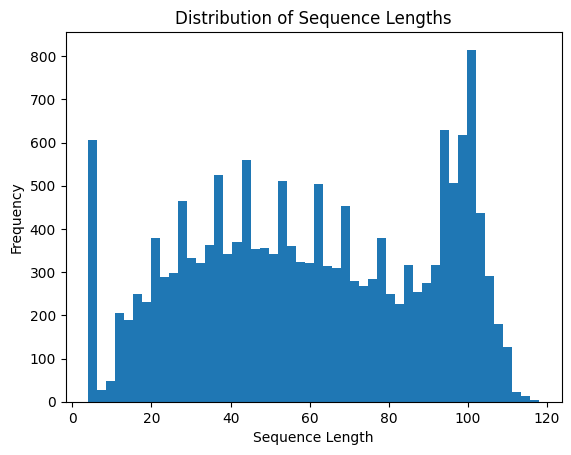

In [87]:
# Computing the maximum sequence length from the training data:

sequence_lengths = [len(seq) for seq in train_text_sequences]
max_seq_length = max(sequence_lengths)
print(f"Maximum Sequence Length: {max_seq_length}")

## let's plot the sequences length :
import matplotlib.pyplot as plt

plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [88]:
# Pad sequences

train_text = pad_sequences(train_text_sequences, maxlen=max_seq_length, padding='post')
test_text= pad_sequences(test_text_sequences, maxlen=max_seq_length, padding='post')

print(f"Sample train padded: {train_text[:2]}")
print(f"Sample test padded: {test_text[:2]}")


Sample train padded: [[  36   59   49  241  497  835    3  570    3   65    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 157 1689  135 1002    2   71  298  194 1051   12    7   17    3   54
   182    5    8  101   12   32    2 1171   60    1   98   47   18  234
    23   10    2  229    7    8   31 5751   47   15   47    9  654   21
     2  120   20  753    5   48    2 1754    5    9   98  106   85   16
    39  559  251    1   24  665   16   65    3   26  265   10    1  185
   665   7

In [65]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

glove_path = '/content/drive/My Drive/glove.6B.100d.txt'

# Loading GloVe embeddings
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')


Found 400000 word vectors.


In [ ]:
embedding_dim = 100

# Preparing embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
